# Load Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import TensorBoard
from keras.utils import to_categorical

# Loading and Preparing the Data

In [2]:
# Set a random seed for reproducibility.
np.random.seed(1145)
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

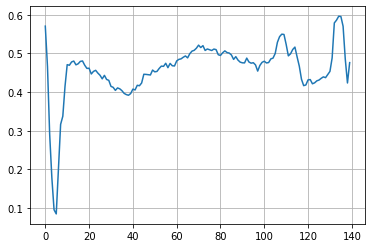

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(140), train_data[0])
plt.show()

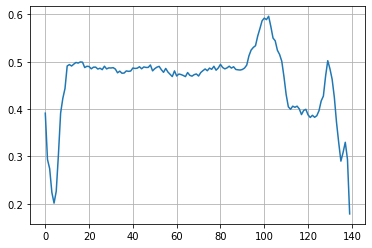

In [4]:
plt.grid()
plt.plot(np.arange(140), train_data[100])
plt.show()

All the above code for loading and preparing the data was provided by Richard Jiang.

In [5]:
# the model requires a 3-dimensional input therefore, we need to expand the 
# dimensions of the training and testing data.
train_data = np.expand_dims(train_data, 2)
test_data = np.expand_dims(test_data, 2)

# the model requires these to be in binary matrix form.
train_classes = to_categorical(train_labels, 2)
test_classes = to_categorical(test_labels, 2)

# Define Model Architecture

In [17]:
#define the input shape for this data.
input_shape = (140, 1)

def buildmodel(epochs, batch_size):
  #initiate a sequential keras model (sequential for simplicity)
  model = Sequential()
  #first, a LSTM layer
  model.add(LSTM(100, input_shape=input_shape))
  #dropout layer to reduce overfitting
  model.add(Dropout(0.5)) 
  #fully-connected layer
  model.add(Dense(100, activation='relu'))
  #output layer
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	#fit network to the data
  model.fit(train_data, train_classes, epochs=epochs, batch_size=batch_size,
           shuffle=True, validation_data=(test_data, test_classes),
           callbacks=[TensorBoard(log_dir='/tmp/model_cnn')])
  return model



# Optimise Parameters

Determine number of epochs.

Epoch 1/15
32/32 [==============================] - 12s 305ms/step - loss: 0.6414 - accuracy: 0.5768 - val_loss: 0.3878 - val_accuracy: 0.8870
Epoch 2/15
32/32 [==============================] - 10s 303ms/step - loss: 0.3488 - accuracy: 0.9078 - val_loss: 0.2844 - val_accuracy: 0.9510
Epoch 3/15
32/32 [==============================] - 9s 284ms/step - loss: 0.2512 - accuracy: 0.9520 - val_loss: 0.1258 - val_accuracy: 0.9580
Epoch 4/15
32/32 [==============================] - 9s 280ms/step - loss: 0.1066 - accuracy: 0.9638 - val_loss: 0.0603 - val_accuracy: 0.9770
Epoch 5/15
32/32 [==============================] - 9s 292ms/step - loss: 0.0830 - accuracy: 0.9725 - val_loss: 0.0785 - val_accuracy: 0.9750
Epoch 6/15
32/32 [==============================] - 9s 295ms/step - loss: 0.0769 - accuracy: 0.9756 - val_loss: 0.0665 - val_accuracy: 0.9750
Epoch 7/15
32/32 [==============================] - 9s 292ms/step - loss: 0.1074 - accuracy: 0.9658 - val_loss: 0.0818 - val_accuracy: 0.9720
Epoc

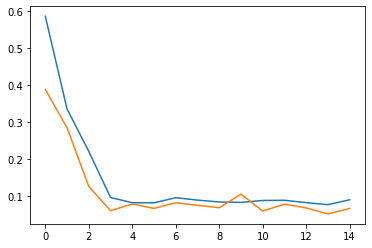

In [19]:
#build the model 
model = buildmodel(15, 128)
#plot the loss and the value loss over the different epochs.
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])

It seems to stablise by 12 epochs.

Need to repeat optimisation experiments various times for accuracy.

In [20]:
def buildmultiple(epochs, batch_size):
  #initiate accuracy list.
  repeat_accuracy = []*10
  #for each repeat
  for i in range(10):
    #build the model
    model = buildmodel(epochs, batch_size)
    #measure and record the accuracy
    loss, accuracy = model.evaluate(test_data, test_classes, 
                                          batch_size=batch_size)
    repeat_accuracy.append(accuracy)
  return repeat_accuracy

Batch Size

Epoch 1/12
500/500 [==============================] - 37s 70ms/step - loss: 0.4697 - accuracy: 0.7918 - val_loss: 0.2472 - val_accuracy: 0.9260
Epoch 2/12
500/500 [==============================] - 35s 69ms/step - loss: 0.1463 - accuracy: 0.9547 - val_loss: 0.2889 - val_accuracy: 0.8900
Epoch 3/12
500/500 [==============================] - 35s 69ms/step - loss: 0.2185 - accuracy: 0.9292 - val_loss: 0.2333 - val_accuracy: 0.9100
Epoch 4/12
500/500 [==============================] - 35s 69ms/step - loss: 0.1878 - accuracy: 0.9399 - val_loss: 0.1059 - val_accuracy: 0.9540
Epoch 5/12
500/500 [==============================] - 35s 70ms/step - loss: 0.1343 - accuracy: 0.9583 - val_loss: 0.1628 - val_accuracy: 0.9460
Epoch 6/12
500/500 [==============================] - 35s 69ms/step - loss: 0.1296 - accuracy: 0.9575 - val_loss: 0.0902 - val_accuracy: 0.9600
Epoch 7/12
500/500 [==============================] - 35s 70ms/step - loss: 0.1475 - accuracy: 0.9491 - val_loss: 0.1336 - val_accuracy:

{'boxes': [<matplotlib.lines.Line2D at 0x7fb384fa3ba8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb3858a63c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb38aebf278>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb386553ac8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb384fa3cc0>,
  <matplotlib.lines.Line2D at 0x7fb39218d668>]}

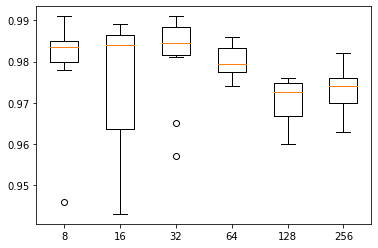

In [21]:
#list of batch sizes to be tested.
batch = [8, 16, 32, 64, 128, 256]

#initiate accuracy list.
batch_accuracy = []*6

#repeat following steps for each batch size.
for i in range(len(batch)):
  accuracy = buildmultiple(12, batch[i])
  batch_accuracy.append(accuracy)  

#boxplot of the accuracy scores against the corresponding batch sizes 
#investigated. 
plt.boxplot(batch_accuracy, labels = batch)

32 seems like the best choice.

Much of the above code was taken from Jason Brownlee (https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/) and manipulated for the ECG data.

# Model Performance

Performance Metrics for data provided.

In [22]:
#initiate performance metrics lists.
accuracy1 = []*10
precision1 = []*10
recall1 = []*10
f1_1 = []*10

#repeat 10 times for accuracy.
for i in range(10):
  #build model and predict for the test data.
  model1 = buildmodel(12, 32)
  #calculate and record performance metrics.
  pred1 = model1.predict_classes(test_data)
  accuracy1.append(accuracy_score(test_labels, pred1))
  precision1.append(precision_score(test_labels, pred1))
  recall1.append(recall_score(test_labels, pred1))
  f1_1.append(f1_score(test_labels, pred1))

Epoch 1/12
125/125 [==============================] - 15s 102ms/step - loss: 0.5450 - accuracy: 0.7126 - val_loss: 0.1418 - val_accuracy: 0.9600
Epoch 2/12
125/125 [==============================] - 12s 99ms/step - loss: 0.1384 - accuracy: 0.9570 - val_loss: 0.0936 - val_accuracy: 0.9620
Epoch 3/12
125/125 [==============================] - 12s 98ms/step - loss: 0.1211 - accuracy: 0.9618 - val_loss: 0.0605 - val_accuracy: 0.9770
Epoch 4/12
125/125 [==============================] - 12s 98ms/step - loss: 0.1033 - accuracy: 0.9610 - val_loss: 0.0664 - val_accuracy: 0.9820
Epoch 5/12
125/125 [==============================] - 12s 97ms/step - loss: 0.0794 - accuracy: 0.9754 - val_loss: 0.0505 - val_accuracy: 0.9840
Epoch 6/12
125/125 [==============================] - 12s 97ms/step - loss: 0.0666 - accuracy: 0.9798 - val_loss: 0.0745 - val_accuracy: 0.9720
Epoch 7/12
125/125 [==============================] - 12s 99ms/step - loss: 0.0821 - accuracy: 0.9761 - val_loss: 0.0705 - val_accuracy

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/12
125/125 [==============================] - 15s 102ms/step - loss: 0.4740 - accuracy: 0.7534 - val_loss: 0.1300 - val_accuracy: 0.9590
Epoch 2/12
125/125 [==============================] - 12s 98ms/step - loss: 0.1111 - accuracy: 0.9625 - val_loss: 0.0921 - val_accuracy: 0.9640
Epoch 3/12
125/125 [==============================] - 12s 97ms/step - loss: 0.1141 - accuracy: 0.9599 - val_loss: 0.2036 - val_accuracy: 0.9560
Epoch 4/12
125/125 [==============================] - 13s 105ms/step - loss: 0.1815 - accuracy: 0.9476 - val_loss: 0.1127 - val_accuracy: 0.9620
Epoch 5/12
125/125 [==============================] - 13s 101ms/step - loss: 0.1078 - accuracy: 0.9664 - val_loss: 0.0881 - val_accuracy: 0.9650
Epoch 6/12
125/125 [==============================] - 12s 98ms/step - loss: 0.1577 - accuracy: 0.9496 - val_loss: 0.0875 - val_accuracy: 0.9730
Epoch 7/12
125/125 [==============================] - 12s 97ms/step - loss: 0.1006 - accuracy: 0.9689 - val_loss: 0.0828 - val_accura

Load in a second dataset for comparison (the data was taken from these sources: https://www.kaggle.com/shayanfazeli/heartbeat?select=ptbdb_abnormal.csv and https://www.kaggle.com/shayanfazeli/heartbeat?select=ptbdb_normal.csv). 2500 observations were taken from each and then combined into the dataset used below.

In [23]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/chloeworthington/SCC413-Computer-Vision-Coursework/main/ecgdata.csv', header = None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,0.681260,0.616743,0.624424,0.619816,0.596006,0.627496,0.631336,0.619048,0.612903,0.613671,0.607527,0.586790,0.568356,0.543779,0.526882,0.552995,0.577573,0.592166,0.576037,0.579109,0.573733,0.589862,0.542243,0.519201,0.514593,0.528418,0.493856,0.485407,0.461598,0.478495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,0.357671,0.379852,0.375231,0.397412,0.388170,0.378004,0.398336,0.419593,0.427911,0.402033,0.378928,0.400185,0.406654,0.422366,0.402033,0.383549,0.398336,0.393715,0.417745,0.388170,0.360444,0.402957,0.392791,0.413124,0.377079,0.327172,0.346580,0.338262,0.356747,0.314233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,0.285566,0.343718,0.281412,0.281412,0.283489,0.281412,0.319834,0.311526,0.283489,0.278297,0.274143,0.317757,0.267913,0.275182,0.280374,0.255452,0.313603,0.266874,0.244029,0.198339,0.192108,0.190031,0.134995,0.086189,0.078920,0.036345,0.024922,0.000000,0.044652,0.024922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


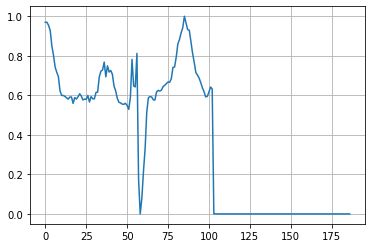

In [25]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(187), train_data[0])
plt.show()

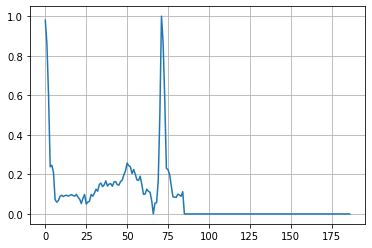

In [26]:
plt.grid()
plt.plot(np.arange(187), train_data[100])
plt.show()

In [27]:
# the model requires a 3-dimensional input therefore, we need to expand the 
# dimensions of the training and testing data.
train_data = np.expand_dims(train_data, 2)
test_data = np.expand_dims(test_data, 2)

# the model requires these to be in binary matrix form.
train_classes = to_categorical(train_labels, 2)
test_classes = to_categorical(test_labels, 2)

Performance metrics for second data.

In [28]:
#initiate performance metrics lists.
accuracy2 = []*10
precision2 = []*10
recall2 = []*10
f1_2 = []*10

#change input shape
input_shape = (187, 1)

#repeat 10 times for accuracy.
for i in range(10):
  #build model and predict for the test data.
  model2 = buildmodel(12, 32)
  #calculate and record performance metrics.
  pred2 = model2.predict_classes(test_data)
  accuracy2.append(accuracy_score(test_labels, pred2))
  precision2.append(precision_score(test_labels, pred2))
  recall2.append(recall_score(test_labels, pred2))
  f1_2.append(f1_score(test_labels, pred2))

Epoch 1/12
125/125 [==============================] - 17s 121ms/step - loss: 0.6932 - accuracy: 0.5158 - val_loss: 0.6929 - val_accuracy: 0.5220
Epoch 2/12
125/125 [==============================] - 14s 115ms/step - loss: 0.6935 - accuracy: 0.5017 - val_loss: 0.6923 - val_accuracy: 0.5290
Epoch 3/12
125/125 [==============================] - 14s 116ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6907 - val_accuracy: 0.5320
Epoch 4/12
125/125 [==============================] - 14s 113ms/step - loss: 0.6942 - accuracy: 0.4818 - val_loss: 0.6933 - val_accuracy: 0.4770
Epoch 5/12
125/125 [==============================] - 14s 116ms/step - loss: 0.6930 - accuracy: 0.5146 - val_loss: 0.6932 - val_accuracy: 0.4800
Epoch 6/12
125/125 [==============================] - 15s 117ms/step - loss: 0.6929 - accuracy: 0.5206 - val_loss: 0.6931 - val_accuracy: 0.5520
Epoch 7/12
125/125 [==============================] - 14s 116ms/step - loss: 0.6938 - accuracy: 0.4686 - val_loss: 0.6935 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/12
125/125 [==============================] - 17s 121ms/step - loss: 0.6936 - accuracy: 0.5023 - val_loss: 0.6927 - val_accuracy: 0.5210
Epoch 2/12
125/125 [==============================] - 14s 114ms/step - loss: 0.6939 - accuracy: 0.5025 - val_loss: 0.6929 - val_accuracy: 0.4770
Epoch 3/12
125/125 [==============================] - 14s 114ms/step - loss: 0.6937 - accuracy: 0.4877 - val_loss: 0.6934 - val_accuracy: 0.4790
Epoch 4/12
125/125 [==============================] - 15s 119ms/step - loss: 0.6934 - accuracy: 0.4808 - val_loss: 0.6939 - val_accuracy: 0.4790
Epoch 5/12
125/125 [==============================] - 15s 120ms/step - loss: 0.6931 - accuracy: 0.5151 - val_loss: 0.6936 - val_accuracy: 0.4790
Epoch 6/12
125/125 [==============================] - 14s 115ms/step - loss: 0.6934 - accuracy: 0.5066 - val_loss: 0.6934 - val_accuracy: 0.4790
Epoch 7/12
125/125 [==============================] - 14s 116ms/step - loss: 0.6933 - accuracy: 0.5060 - val_loss: 0.6938 - val_ac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/12
125/125 [==============================] - 17s 121ms/step - loss: 0.6936 - accuracy: 0.4938 - val_loss: 0.7059 - val_accuracy: 0.4790
Epoch 2/12
125/125 [==============================] - 14s 115ms/step - loss: 0.6950 - accuracy: 0.4952 - val_loss: 0.6939 - val_accuracy: 0.4790
Epoch 3/12
125/125 [==============================] - 14s 115ms/step - loss: 0.6932 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.5170
Epoch 4/12
125/125 [==============================] - 14s 114ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6936 - val_accuracy: 0.4800
Epoch 5/12
125/125 [==============================] - 14s 115ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6936 - val_accuracy: 0.4790
Epoch 6/12
125/125 [==============================] - 15s 121ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6937 - val_accuracy: 0.4790
Epoch 7/12
125/125 [==============================] - 16s 126ms/step - loss: 0.6928 - accuracy: 0.5101 - val_loss: 0.6945 - val_ac

Collate the performance metrics into a dataframe and save for later direct comparison.

In [29]:
lstmperf = pd.DataFrame()
lstmperf["Accuracy1"] = accuracy1
lstmperf["Precision1"] = precision1
lstmperf["Recall1"] = recall1
lstmperf["F1Score1"] = f1_1
lstmperf["Accuracy2"] = accuracy2
lstmperf["Precision2"] = precision2
lstmperf["Recall2"] = recall2
lstmperf["F1Score2"] = f1_2

lstmperf.to_csv("LSTM_performance_metrics.csv")